In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp
import gc

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(10_000, xp)

xp = numpy


In [3]:
%run sequencing_sp2.ipynb

In [267]:
def create_matrix(m, n):
  '''Creates a random matrix of shape mxn for testing.'''  
  M = np.random.rand(m, n)  # Generate random matrix of size m x n
  print('The original matrix M:\n', M)  
  print('M shape:', M.shape)  # Print the shape for reference
  return M

def decompose_matrix(M):
  '''Decomposes the matrix M using Singular Value Decomposition (SVD).'''
  U, S, V = np.linalg.svd(M)  # Perform SVD 
  print('U shape:', U.shape) 
  print('S shape:', S.shape)
  print('V shape:', V.shape)

  # Adjust matrix shapes to ensure U (m x n), S (n x n), V (n x n):
  U = U[:, :S.shape[0]]  # Limit U to the number of singular values 
  S = np.diag(S)  # Convert S (a vector) into a diagonal matrix
  print('Adjusted U shape:', U.shape)
  print('Adjusted S shape:', S.shape)
  print('Adjusted V shape:', V.shape)

  return U, S, V

# def reconstruct_matrix(U, S, V, r):
#   '''Reconstructs the matrix using the SVD components with rank r.''' 
#   # print('\nReconstructing matrix with rank=', r)
#   R = U[:, :r] @ S[:r, :r] @ V[:r, :]  # Use rank-reduced components for approximation 
#   # print(R)
#   # print('R shape:', R.shape)  # Output shape of the approximated matrix
#   return R

def reconstruct_matrix(U, S, V, ranks):
    return U[:, ranks] @ np.take(np.take(S, ranks, axis=0), ranks, axis=1) @ V[ranks, :]

def compare_matrices(M, R):
  '''Calculates the difference and relative difference between the original and 
      reconstructed matrix.'''
  D = M - R  # Element-wise difference
  M_norm = np.linalg.norm(M, 'fro')  # Frobenius norm of original matrix
  D_norm = np.linalg.norm(D, 'fro')  # Frobenius norm of difference matrix
  print('Diff:\n', np.array_str(D, precision=2, suppress_small=True))  # Print differences
  return D_norm / M_norm  # Calculate the relative difference ratio


In [5]:
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')

In [47]:
image_id = RNG.choice(df_train_images.index)

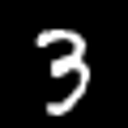

In [48]:
df_image = df_train_images.loc[image_id]
Image.open(io.BytesIO(df_image['png']))

In [25]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

In [305]:
BLOCKS_COUNT = 100
BLOCK_LEN = 5
SEQ_LV_MAT_SHAPE = (BLOCKS_COUNT, BLOCK_LEN, 2)

def calc_seq_lv_mat(sequences, si_ind_dict, cache={}):
    seq_lv_mat = np.zeros(SEQ_LV_MAT_SHAPE, dtype='f').reshape(-1, 2)
    assert sequences
    # assert len(sequences) <= SEQ_SUBLVS_COUNT

    xy_prev_seq_tail = np.zeros(2)
    block_index = 0
    
    for sequence_i, sequence in enumerate(sequences):
        assert sequence
        # print(f'sequence len={len(sequence)}')
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        
        if sequence_i == 0:
            ingress_vec = np.array([0, 0])
        else:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last
        
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence = vec_sequence[:-1] # get rid of reciprocal vector which connects tail to tip

        is_block_switch = True
        row_index = 0

        for si_ind, vec in zip(sequence, vec_sequence):
            if is_block_switch:
                is_block_switch = False
                row_index = block_index * BLOCK_LEN
                seq_lv_mat[row_index] = ingress_vec
                # print(f'{block_index}:{row_index} = {ingress_vec}')
                row_index += 1
                ingress_vec = np.array([0, 0])
                
            seq_lv_mat[row_index] = vec
            # print(f'{block_index}:{row_index} = {vec}')
            row_index += 1

            if (row_index % BLOCK_LEN) == 0:
                is_block_switch = True
                block_index += 1

        if is_block_switch == False:
            block_index += 1

        # print('end')
        

    return seq_lv_mat.reshape((BLOCKS_COUNT, -1))

In [306]:
si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
sequences = pickle.loads(df_image['inner_sequences'])

MAX_SEQUENCES_COUNT = 5

if len(sequences) > MAX_SEQUENCES_COUNT:
    seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
else:
    seq_indices = list(range(len(sequences)))
    
assert len(seq_indices) <= MAX_SEQUENCES_COUNT

seq_lv_codes = []

for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
    for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
        seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))

cache = {}
seq_lv_mats = []

for seq_lv_code in seq_lv_codes:
    sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
    seq_lv_mat = calc_seq_lv_mat(sequences_reading, si_ind_dict, cache)
    seq_lv_mats.append(seq_lv_mat)

In [307]:
len(seq_lv_mats)

48

In [308]:
# calc_seq_lv_mat(sequences_reading, si_ind_dict, cache)[:,:10]

In [309]:
def render_seq_lv_mat(seq_lv_mat, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
    xy = offset

    # for vec in zip(seq_lv_mat.reshape(-1, 2), np.roll(seq_lv_mat.reshape(-1, 2), -1, axis=0)):
    for vec_ind, vec in enumerate(seq_lv_mat.reshape(-1, 2)):
        xy_old = xy
        draw.rectangle([xy[0] - 1, xy[1] - 1, xy[0] + 1, xy[1] + 1], width=1, fill='green')
        xy = xy + k * vec
        draw.rectangle([xy[0] - 1, xy[1] - 1, xy[0] + 1, xy[1] + 1], width=1, fill='green')

        if vec_ind % BLOCK_LEN != 0:
            draw.line([xy_old[0], xy_old[1], xy[0], xy[1]], width=1, fill='green')
        
    return image_pil

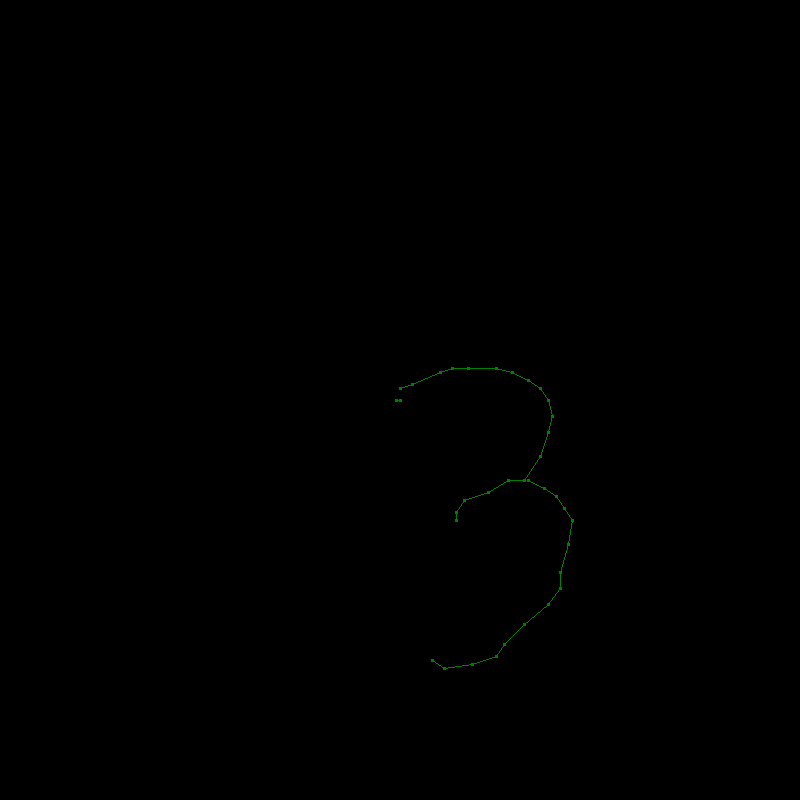

In [310]:
render_seq_lv_mat(seq_lv_mat, k=4)

In [311]:
U, S, V = decompose_matrix(seq_lv_mat)

U shape: (100, 100)
S shape: (10,)
V shape: (10, 10)
Adjusted U shape: (100, 10)
Adjusted S shape: (10, 10)
Adjusted V shape: (10, 10)


In [318]:
-np.sort(-np.unique(S)), -np.round(np.sort(-np.unique(S ** 2)), decimals=0), -np.round(np.sort(-(np.unique(S ** 2) / np.sum((S ** 2).ravel()))), decimals=2) 

(array([73.72683   , 30.468838  , 20.75542   , 13.339522  ,  5.694585  ,
         3.8836322 ,  2.9359508 ,  2.1553307 ,  0.6949979 ,  0.12478048,
         0.        ], dtype=float32),
 array([5.436e+03, 9.280e+02, 4.310e+02, 1.780e+02, 3.200e+01, 1.500e+01,
        9.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       dtype=float32),
 array([0.77, 0.13, 0.06, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       dtype=float32))

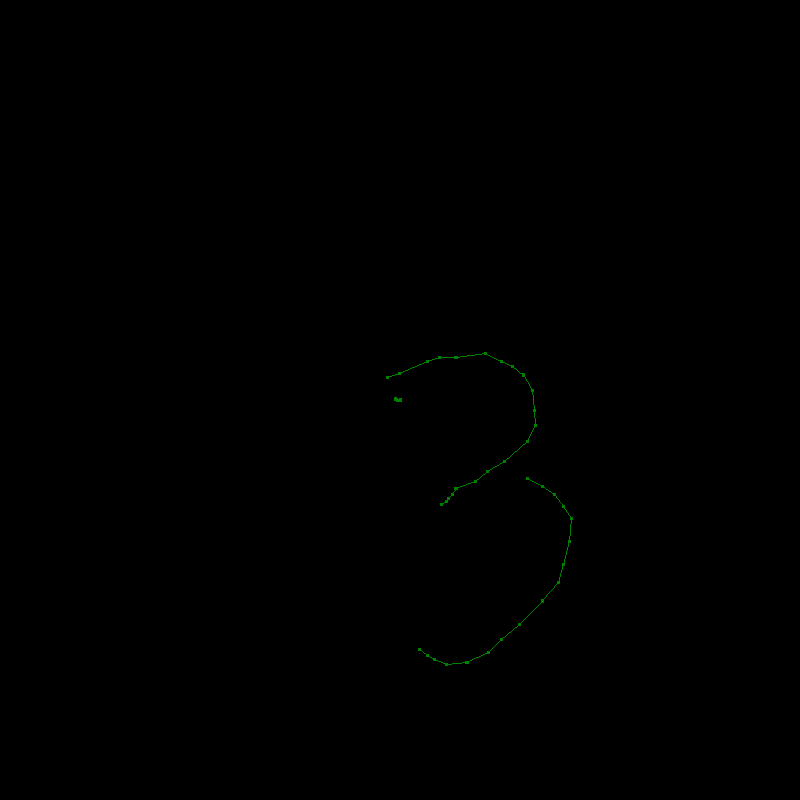

In [313]:
# seq_lv_mat_r = reconstruct_matrix(U, S, V, 8)
ranks = [0, 1, 2, 3]
# r = 1
# seq_lv_mat_r = U[:, :1] @ S[:1, :1] @ V[:1, :]  # Use rank-reduced components for approximation 
# seq_lv_mat_r = U[:, ranks] @ np.take(np.take(S, ranks, axis=0), ranks, axis=1) @ V[ranks, :]
seq_lv_mat_r = reconstruct_matrix(U, S, V, ranks)
render_seq_lv_mat(seq_lv_mat_r, k=4)

In [314]:
seq_lv_mat2 = seq_lv_mats[RNG.choice(len(seq_lv_mats) - 1)]
U2, S2, V2 = decompose_matrix(seq_lv_mat2)

U shape: (100, 100)
S shape: (10,)
V shape: (10, 10)
Adjusted U shape: (100, 10)
Adjusted S shape: (10, 10)
Adjusted V shape: (10, 10)


In [315]:
-np.sort(-np.unique(S2)), -np.round(np.sort(-np.unique(S2 ** 2)), decimals=0), -np.round(np.sort(-(np.unique(S2 ** 2) / np.sum((S2 ** 2).ravel()))), decimals=2) 

(array([65.55981   , 22.749207  , 15.925445  ,  5.8483686 ,  5.6032314 ,
         3.316831  ,  2.637631  ,  1.6878026 ,  0.54041433,  0.25847808,
         0.        ], dtype=float32),
 array([4.298e+03, 5.180e+02, 2.540e+02, 3.400e+01, 3.100e+01, 1.100e+01,
        7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       dtype=float32),
 array([0.83, 0.1 , 0.05, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       dtype=float32))

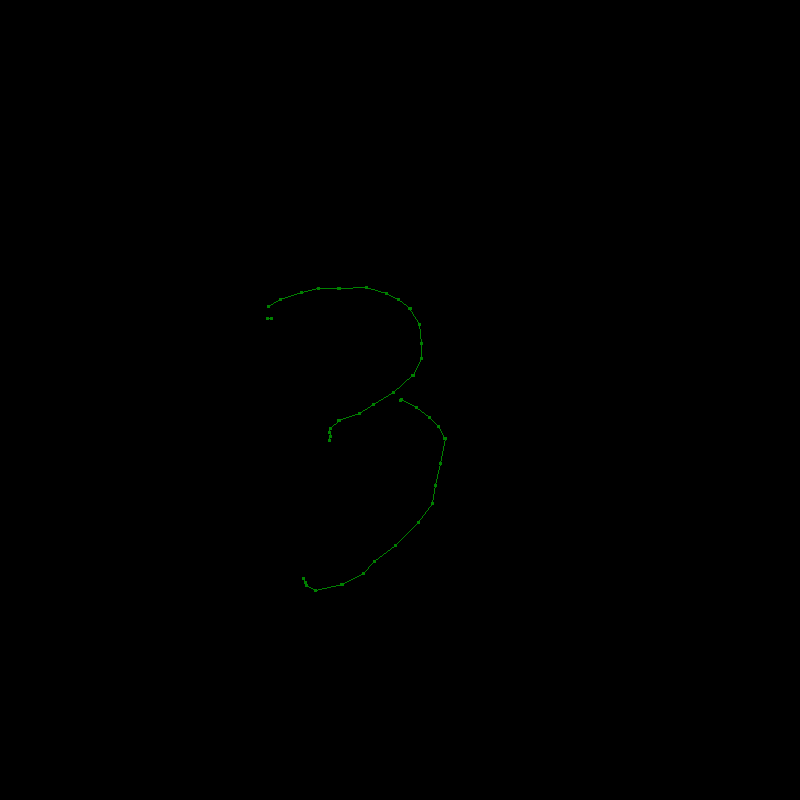

In [316]:
seq_lv_mat_r2 = reconstruct_matrix(U2, S2, V2, ranks)
render_seq_lv_mat(seq_lv_mat_r2, k=4)

In [ ]:
# # Test the functions with sample values:
# m = 10
# n = 5
# M = create_matrix(m, n)  # Create the matrix

# U, S, V = decompose_matrix(M)  # Decompose with SVD 

# R1 = reconstruct_matrix(U, S, V, n)  # Full reconstruction (using all singular values)
# diff_ratio1 = compare_matrices(M, R1)
# print(f'Diff ratio 1: {diff_ratio1:.2f}')

# R2 = reconstruct_matrix(U, S, V, 1)  # Reduced-rank reconstruction
# diff_ratio2 = compare_matrices(M, R2)
# print(f'Diff ratio 2: {diff_ratio2:.2f}')